# 0.0 Imports

In [1]:
import numpy   as np
import pandas  as pd
import seaborn as sns

from IPython.display     import HTML
from matplotlib          import pyplot  as plt
from sklearn             import cluster as c
from sklearn             import metrics as m
from plotly              import express as px
from yellowbrick.cluster import KElbowVisualizer

## 0.1. Helper Functions

In [3]:
def jupyter_settings():
    %matplotlib inline
    
    display( HTML('<style>.container { width:100% !important; }</style>'))
#     pd.options.display.max_columns = None
#     pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
        
jupyter_settings()

## 0.2. Load dataset

In [4]:
# load data
df_raw = pd.read_csv('../data/raw/Ecommerce.csv', encoding='unicode_escape')

df_raw

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Unnamed: 8
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom,NaN
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom,NaN
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,7-Dec-17,0.85,12680.0,France,NaN
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,7-Dec-17,2.10,12680.0,France,NaN
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,7-Dec-17,4.15,12680.0,France,NaN
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,7-Dec-17,4.15,12680.0,France,NaN


In [3]:
# drop extra column
df_raw = df_raw.drop(columns=['Unnamed: 8'], axis=1)

# 1.0 Data description

In [4]:
df1 = df_raw.copy()

## 1.1 Rename columuns

In [5]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols_new

## 1.2 Data types

In [6]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.3 Check NA

In [7]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.4 Replace NA

In [8]:
# remove na
df1 = df1.dropna(subset=['description', 'customer_id'])
print('Removed data: {:.2f}'.format(1-( df1.shape[0] / df_raw.shape[0])))

Removed data: 0.25


In [9]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

## 1.5 Change dtypes

In [10]:
# invoice date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# customer id
df1['customer_id'] = df1['customer_id'].astype(int)
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom


In [11]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

## <font color='red'> 1.6 Descriptive statistics </font>

# 2.0 Feature engineering 

In [112]:
df2 = df1.copy()

## 2.1 Feature creation

In [113]:
# data reference
df_ref = df2.drop(['invoice_no', 'stock_code', 'description', 
                    'quantity', 'invoice_date', 'unit_price', 
                    'country'], axis=1 ).drop_duplicates(ignore_index=True)

# Gross Revenue - quantity * price
df2['gross_revenue'] = df2['quantity'] * df2['unit_price']


# Monetary
df_monetary = df2[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')


# Recency - Last day of purchase
df_recency = df2[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')


# Frequency
df_freq = df2[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')


# Avg Ticket
df_avg_ticket = df2[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})
df_ref = pd.merge(df_ref, df_avg_ticket, on='customer_id', how='left')

# <font color='red'> 3.0 Variable filtering </font>

In [114]:
df3 = df_ref.copy()

# <font color='red'> 4.0 EDA (Exploratory Data Analysis) </font>

In [115]:
df4 = df3.copy()

# <font color='red'> 5.0 Data preparation </font>

In [116]:
df5 = df4.copy()

# <font color='red'> 6.0 Feature selection </font>

In [117]:
df6 = df5.copy()

# 7.0 Hyperparameter Fine-Tunning

In [118]:
X = df6.drop(columns=['customer_id'])

In [119]:
X.head()

,gross_revenue,recency_days,invoice_no,avg_ticket
0,5288.63,302,35,16.950737
1,3079.10,31,18,15.709694
2,7187.34,2,18,28.634821
3,948.25,95,5,33.866071
4,635.10,330,6,105.850000


In [120]:
clusters = [2, 3, 4, 5, 6]

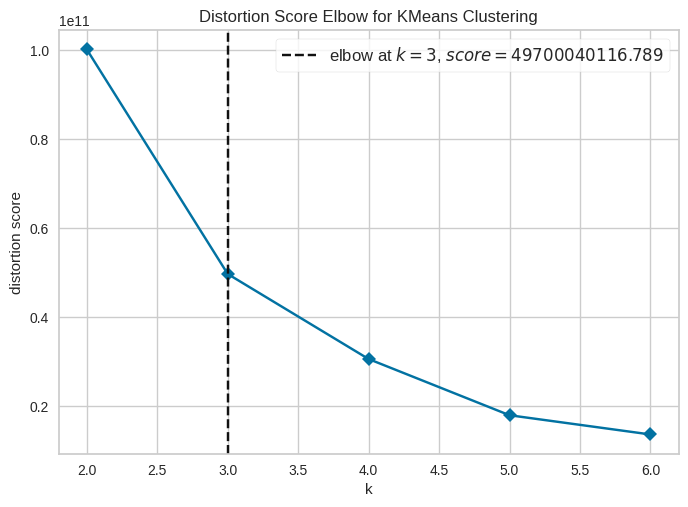

In [121]:
kmeans = KElbowVisualizer(c.KMeans(n_init='auto'),k=clusters, timings=False)
kmeans.fit(X)
kmeans.show();

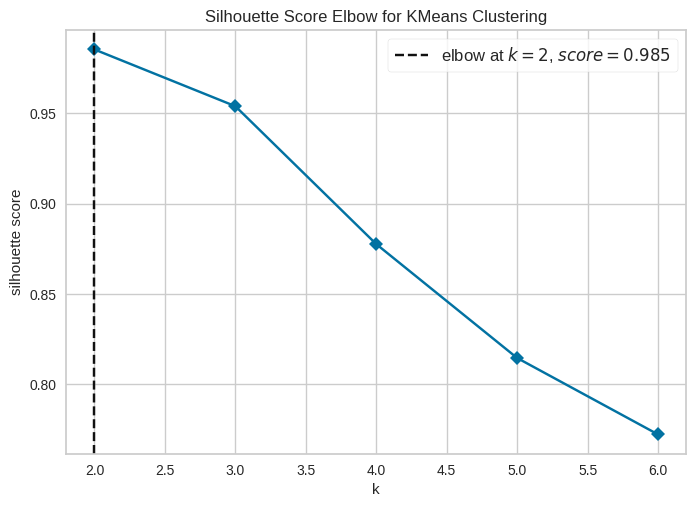

In [122]:
kmeans = KElbowVisualizer( c.KMeans(n_init='auto'), k=clusters, metric='silhouette', timings=False )
kmeans.fit( X )
kmeans.show();

#  8.0 Model training 

## 8.1 K-Means

In [123]:
# model definition
k = 5
kmeans = c.KMeans(n_clusters=k,n_init='auto',random_state=42)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

### 8.2 Cluster validation

In [124]:
## WSS (Within-cluster sum of square)
print('WSS value: {}'.format(kmeans.inertia_))

## SS (Silhouette Score 
print('SS value: {}'.format(m.silhouette_score(X, labels, metric='euclidean')))

WSS value: 17978049633.75989
SS value: 0.8150443172526725


# 9.0 Cluster analysis

In [125]:
df9 = df6.copy()
df9['cluster'] = labels
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,cluster
0,17850,5288.63,302,35,16.950737,4
1,13047,3079.10,31,18,15.709694,0
2,12583,7187.34,2,18,28.634821,4
3,13748,948.25,95,5,33.866071,0
4,15100,635.10,330,6,105.850000,0


## 9.1 Visualization inspection

In [126]:
# fig = px.scatter_3d(df9, x='recency_days', y='invoice_no', z='gross_revenue', color='cluster')
# fig.show()

## 9.2 Cluster profile

In [127]:
df9.sample(10)

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,cluster
1581,18257,2265.38,39,12,18.417724,0
615,16907,981.65,29,5,6.500993,0
2796,13682,59.50,187,1,19.833333,0
3659,15774,270.80,68,1,10.832000,0
2254,14912,841.52,16,3,30.054286,0
1865,14730,2005.06,1,8,4.002116,0
117,15658,958.90,190,8,17.123214,0
3894,13897,311.16,50,1,18.303529,0
4265,16376,977.52,8,3,7.636875,0
3780,17459,657.30,43,2,5.921622,0


In [128]:
# Number of customer
df_cluster = df9[['customer_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['perc_customer'] = 100*( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Avg Gross revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster' )

# Avg recency days
df_avg_recency_days = df9[['recency_days', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency_days, how='inner', on='cluster' )

# Avg invoice_no
df_invoice_no = df9[['invoice_no', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_invoice_no, how='inner', on='cluster' )

df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,invoice_no
0,0,4073,93.161025,948.451054,96.930027,3.648907
1,1,3,0.068618,241136.560000,3.000000,64.666667
2,2,4,0.091491,114451.897500,9.000000,96.500000
3,3,27,0.617566,40928.794815,6.333333,58.259259
4,4,265,6.061299,8115.962038,20.305660,19.528302


### Cluster 01: (Insider Candidate)
    - Number of customers: 3 (0.06% of customers)
    - Average recency: 3 days
    - Purchases on average: 65 purchases
    - Average revenue: $241,136.56 USD
        
### Cluster 02:
    - Number of customers: 4 (0.09 of customers)
    - Average recency: 9 days
    - Purchases on average: 96 purchases
    - Average revenue: $114,451.89 USD
        
### Cluster 03:
    - Number of customers: 14 (0.61% of customers)
    - Average recency: 6 days
    - Purchases on average: 58 purchases
    - Average revenue: $40,928.79 USD
    
### Cluster 04:
    - Number of customers: 265 (6% of customers)
    - Average recency: 20 days
    - Purchases on average: 19 purchases
    - Average revenue: $8115.96 USD
    
### Cluster 05:
    - Number of customers: 4073 (93% of customers)
    - Average recency: 96 days
    - Purchases on average: 4 purchases
    - Average revenue: $948.45 USD

# <font color='red'> 10.0. Deploy To Production </font>